In [100]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

import pathlib
import IPython.display as display
import os
import random

2.0.0-alpha0


### Load Images 

In [101]:
IMG_H, IMG_W = 160, 160
IMAGES_PATH = '../../image_gathering/imgs'
data_root = pathlib.Path(IMAGES_PATH)
print(data_root)

../../image_gathering/imgs


In [102]:
def show_example_images(ds, number=1):
    it = iter(ds)
    print('Example images:')
    for i in range(number):
        image, label = it.next()
        print(f'Class "{labels[label]}"')
        plt.imshow(image)
        plt.show()

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_H, IMG_W])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def load_training_images(data_root):
    if not data_root.exists():
        raise
    # Images' paths
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    
    # Labels
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)
    
    # Extra info
    image_count = len(all_image_paths)
    print(f'Number of images: {image_count}')
    print(f'Label names: {label_names}')
    return image_label_ds, label_names, image_count


In [103]:
# Dataset of preprocessed images
ds, labels, image_count = load_training_images(data_root)

Number of images: 1474
Label names: ['anything', 'ethernet']


Example images:
Class "ethernet"


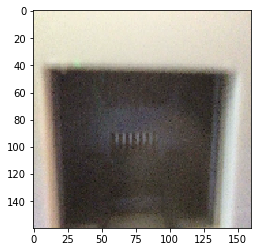

Class "anything"


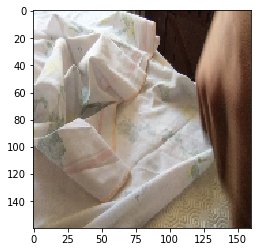

In [104]:
show_example_images(ds, 2)

In [105]:
def dataset_split(ds, image_count, test=0.05, dev=0.05, train=0.9):
    assert (test + dev + train == 1), 'test + dev + train should be equal to 1'
    nt, nd = int(test*image_count), int(dev*image_count)
    ntr = image_count - nt - nd
    ds_test = ds.take(nt) 
    ds_dev = ds.skip(nt).take(nd) 
    ds_train = ds.skip(nt + nd).take(ntr)
    return ds_test, ds_dev, ds_train

In [106]:
ds_test, ds_dev, ds_train = dataset_split(ds, image_count)
print(ds_test)
#show_example_images(ds_test)
#show_example_images(ds_dev)
#show_example_images(ds_train)

<TakeDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int32)>


### Simple Model

In [148]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
IMG_SHAPE = (IMG_H, IMG_W, 3)

# Creating example model (ignore)
def create_model(input_shape):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs = X_input, outputs = X, name='TestModel')
    return model


In [149]:
model = create_model(IMG_SHAPE)

In [150]:
model.summary()

Model: "TestModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 76800)             0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 76801     
Total params: 76,801
Trainable params: 76,801
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile(optimizer = 'adam', loss = "binary_crossentropy", metrics = ["accuracy"])

In [111]:
BATCH_SIZE = 32
initial_epochs = 10
steps_per_epoch = BATCH_SIZE
validation_steps = 20
SHUFFLE_BUFFER_SIZE = 1000

train_batches = ds_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = ds_train.batch(BATCH_SIZE)
test_batches = ds_train.batch(BATCH_SIZE)

In [112]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    verbose=1)

Epoch 1/10
42/42 [==============================] - 49s 1s/step - loss: 1.6099 - accuracy: 0.8230 - val_loss: 0.5824 - val_accuracy: 0.9059
Epoch 2/10
42/42 [==============================] - 47s 1s/step - loss: 0.2956 - accuracy: 0.9480 - val_loss: 0.4207 - val_accuracy: 0.9119
Epoch 3/10
42/42 [==============================] - 47s 1s/step - loss: 0.1981 - accuracy: 0.9533 - val_loss: 0.1171 - val_accuracy: 0.9571
Epoch 4/10
42/42 [==============================] - 47s 1s/step - loss: 0.2671 - accuracy: 0.9277 - val_loss: 0.3285 - val_accuracy: 0.9232
Epoch 5/10
42/42 [==============================] - 47s 1s/step - loss: 0.1245 - accuracy: 0.9661 - val_loss: 0.2834 - val_accuracy: 0.9292
Epoch 6/10
42/42 [==============================] - 47s 1s/step - loss: 0.3484 - accuracy: 0.9300 - val_loss: 0.2334 - val_accuracy: 0.9450
Epoch 7/10
42/42 [==============================] - 47s 1s/step - loss: 0.0908 - accuracy: 0.9752 - val_loss: 0.3817 - val_accuracy: 0.9172
Epoch 8/10
42/42 [==

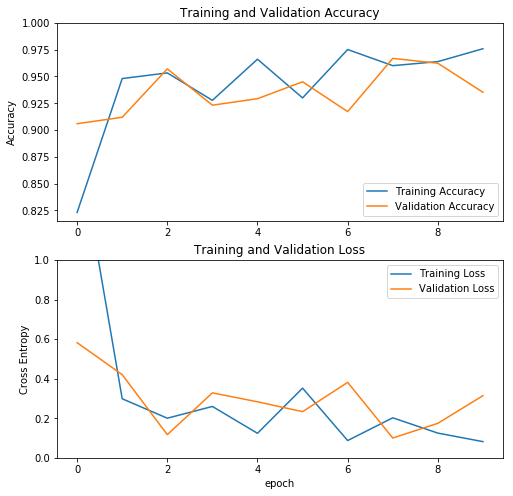

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [114]:
loss0,accuracy0 = model.evaluate(test_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 13s 665ms/step - loss: 0.3113 - accuracy: 0.9312
initial loss: 0.31
initial accuracy: 0.93


Just a quick test but the model doesn't work that bad o.O  
I can see it overfitted the training set a little bit, but still... without convs... pretty cool. I would've dropped the learning rate because the cost is jumping around to much.
Also, because it's just a fully connected layer, it'll probably only detect when the "thing" is on a similar spot as it was in the training, where as in convnets you usually have pooling layers and convolutions to help with that.


## Transfer learning MobileNet V2 trained on ImageNet

In [151]:
IMG_SHAPE = (IMG_H, IMG_W, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [157]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [158]:
img = iter(ds_train.batch(1)).next()[0]
print(img.shape)
feature_batch = base_model(img)
print(feature_batch.shape)

(1, 160, 160, 3)
(1, 5, 5, 1280)


In [159]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(1, 1280)


In [160]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1, 1)


In [161]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [162]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [163]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [165]:
BATCH_SIZE = 32
initial_epochs = 10
steps_per_epoch = BATCH_SIZE
validation_steps = 20
SHUFFLE_BUFFER_SIZE = 1000

train_batches = ds_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = ds_train.batch(BATCH_SIZE)
test_batches = ds_train.batch(BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 24s 1s/step - loss: 5.2032 - accuracy: 0.4000
initial loss: 5.20
initial accuracy: 0.40


In [166]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
42/42 [==============================] - 102s 2s/step - loss: 1.5589 - accuracy: 0.7726 - val_loss: 1.8353 - val_accuracy: 0.6845
Epoch 2/10
42/42 [==============================] - 97s 2s/step - loss: 1.1232 - accuracy: 0.8366 - val_loss: 1.2602 - val_accuracy: 0.8005
Epoch 3/10
42/42 [==============================] - 96s 2s/step - loss: 0.8266 - accuracy: 0.8697 - val_loss: 1.0235 - val_accuracy: 0.8298
Epoch 4/10
42/42 [==============================] - 93s 2s/step - loss: 0.6944 - accuracy: 0.8938 - val_loss: 0.7001 - val_accuracy: 0.8773
Epoch 5/10
42/42 [==============================] - 93s 2s/step - loss: 0.5794 - accuracy: 0.9172 - val_loss: 0.4756 - val_accuracy: 0.9029
Epoch 6/10
42/42 [==============================] - 93s 2s/step - loss: 0.4658 - accuracy: 0.9337 - val_loss: 0.3308 - val_accuracy: 0.9270
Epoch 7/10
42/42 [==============================] - 93s 2s/step - loss: 0.3914 - accuracy: 0.9465 - val_loss: 0.2482 - val_accuracy: 0.9511
Epoch 8/10
42/42 [=

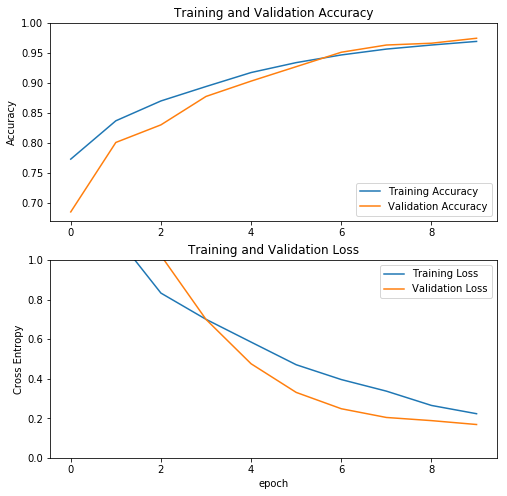

In [167]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [168]:
loss1,accuracy1 = model.evaluate(test_batches, steps = validation_steps)
print("final loss: {:.2f}".format(loss1))
print("final accuracy: {:.2f}".format(accuracy1))

20/20 [==============================] - 23s 1s/step - loss: 0.1546 - accuracy: 0.9734
final loss: 0.15
final accuracy: 0.97


In [169]:
# I don't trust it, lets get more tests :P
NEW_TESTS_PATH = '../../image_gathering/tmp2/'
ds_test2, labels2, image_count2 = load_training_images(pathlib.Path(NEW_TESTS_PATH))

Number of images: 169
Label names: ['eth2']


What it predicts on random images: 
Predicted ethernet for the image below
[[1.9955779]]
1


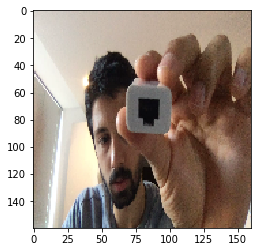

Predicted ethernet for the image below
[[1.3449259]]
1


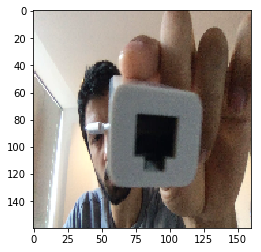

Predicted anything for the image below
[[0.33086365]]
0


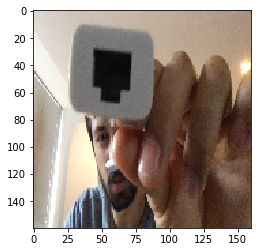

Predicted ethernet for the image below
[[2.4459722]]
1


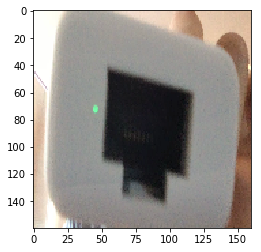

Predicted ethernet for the image below
[[1.4802715]]
1


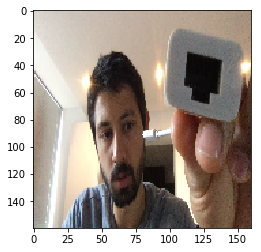

Predicted ethernet for the image below
[[1.17008]]
1


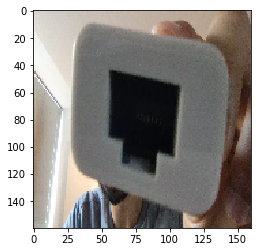

Predicted anything for the image below
[[0.5285096]]
0


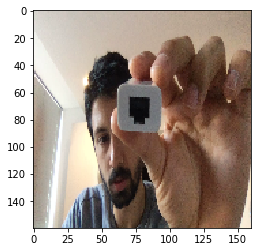

Predicted anything for the image below
[[0.8905022]]
0


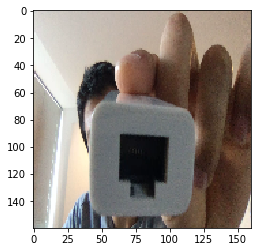

Predicted anything for the image below
[[0.6448641]]
0


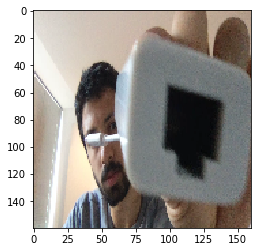

Predicted anything for the image below
[[-0.1761812]]
0


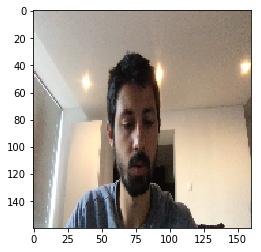

Predicted ethernet for the image below
[[2.616388]]
1


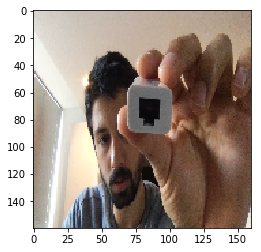

Predicted ethernet for the image below
[[1.6779515]]
1


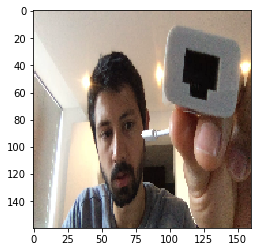

Predicted ethernet for the image below
[[1.00232]]
1


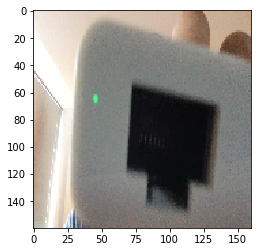

Predicted ethernet for the image below
[[2.2283947]]
1


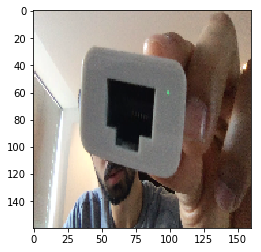

Predicted ethernet for the image below
[[1.3425856]]
1


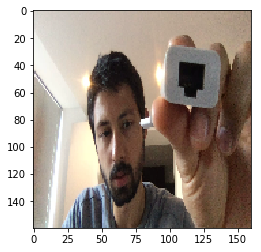

Predicted ethernet for the image below
[[1.2131829]]
1


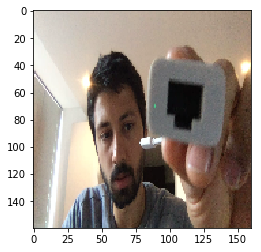

Predicted anything for the image below
[[0.4019754]]
0


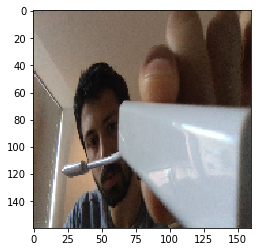

Predicted ethernet for the image below
[[1.5836908]]
1


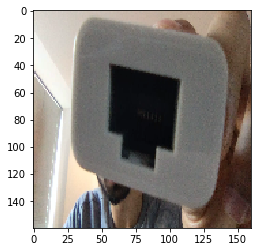

Predicted anything for the image below
[[0.5281336]]
0


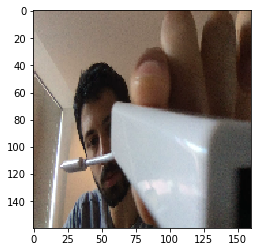

Predicted ethernet for the image below
[[1.3104464]]
1


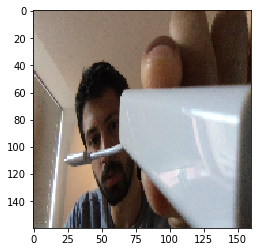

Predicted anything for the image below
[[-1.0999074]]
0


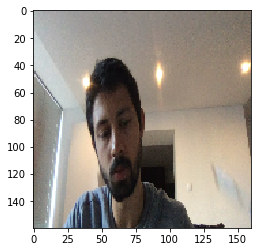

Predicted ethernet for the image below
[[1.1576155]]
1


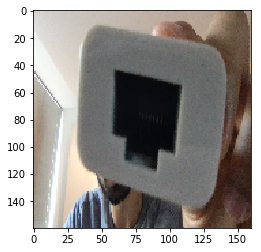

Predicted ethernet for the image below
[[1.3053808]]
1


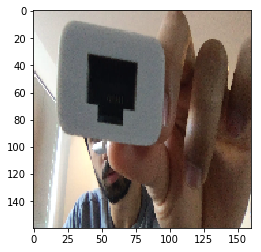

Predicted anything for the image below
[[0.8325497]]
0


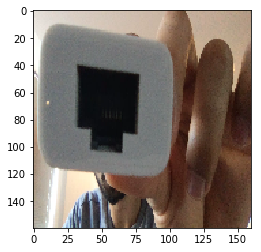

Predicted ethernet for the image below
[[1.6712655]]
1


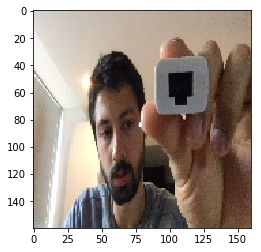

Predicted anything for the image below
[[0.80522037]]
0


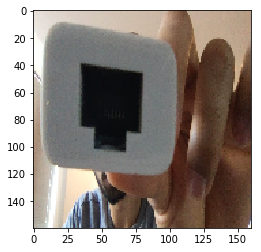

Predicted ethernet for the image below
[[1.4471905]]
1


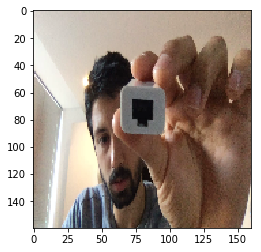

Predicted ethernet for the image below
[[1.664359]]
1


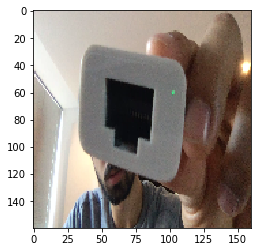

Predicted ethernet for the image below
[[1.3872366]]
1


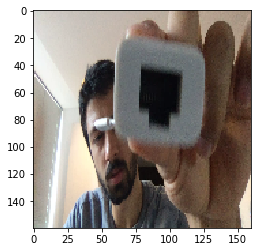

Predicted anything for the image below
[[-0.44782382]]
0


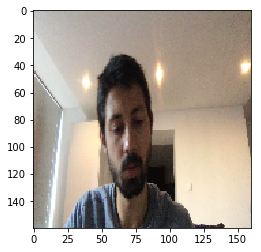

Predicted anything for the image below
[[-0.15308201]]
0


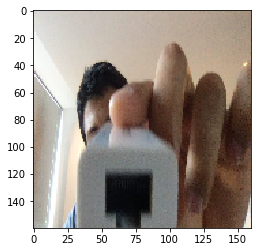

Predicted ethernet for the image below
[[1.8933998]]
1


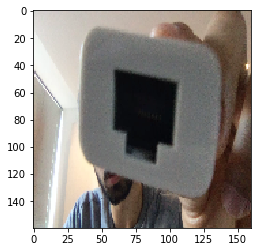

Predicted ethernet for the image below
[[1.1595514]]
1


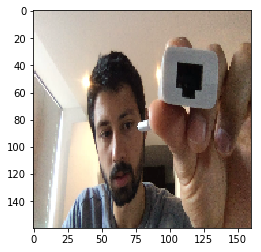

Predicted anything for the image below
[[0.86906636]]
0


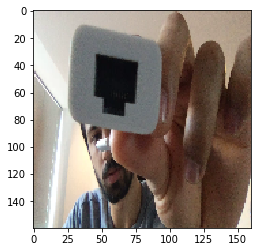

Predicted anything for the image below
[[0.3291861]]
0


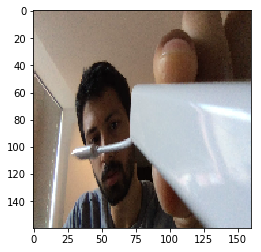

Predicted ethernet for the image below
[[1.5073283]]
1


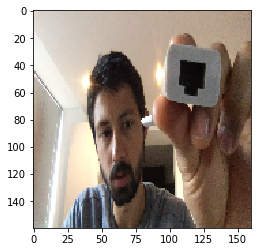

Predicted anything for the image below
[[-0.37820548]]
0


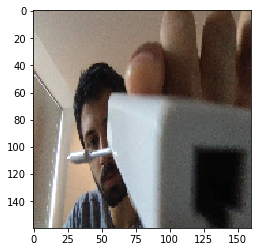

Predicted anything for the image below
[[-0.3335288]]
0


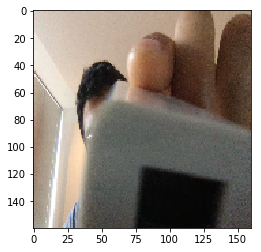

Predicted ethernet for the image below
[[1.6940368]]
1


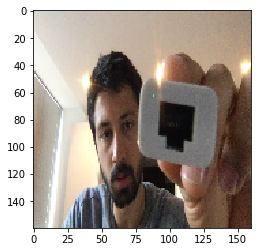

Predicted ethernet for the image below
[[1.4586245]]
1


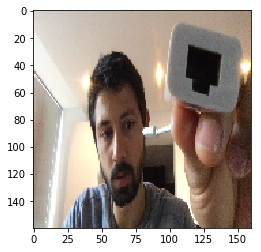

Predicted anything for the image below
[[-0.364415]]
0


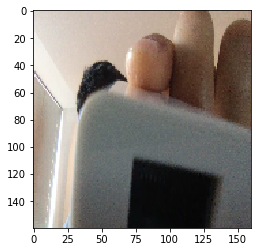

Predicted ethernet for the image below
[[1.325929]]
1


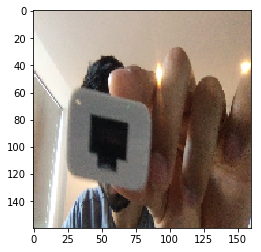

Predicted ethernet for the image below
[[1.1156219]]
1


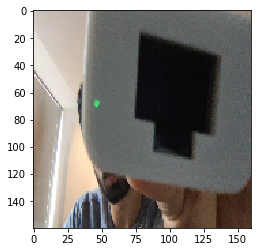

Predicted ethernet for the image below
[[1.6747566]]
1


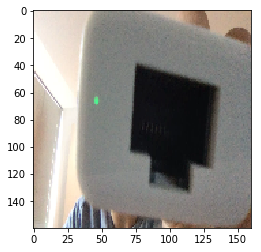

Predicted ethernet for the image below
[[1.1701696]]
1


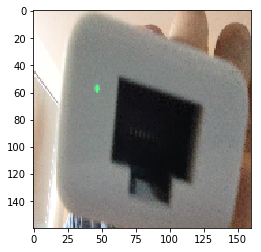

Predicted anything for the image below
[[-0.4869717]]
0


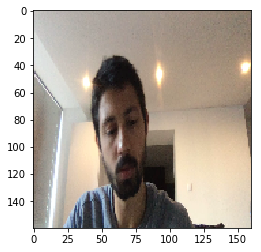

Predicted ethernet for the image below
[[2.1669202]]
1


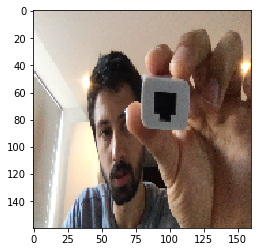

Predicted ethernet for the image below
[[1.7145617]]
1


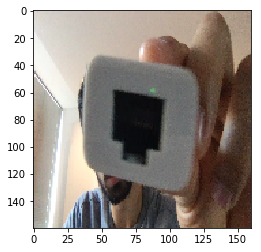

Predicted anything for the image below
[[0.9138]]
0


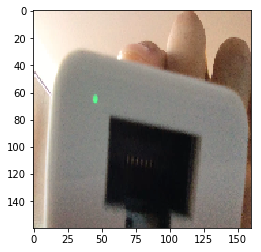

Predicted ethernet for the image below
[[1.7643309]]
1


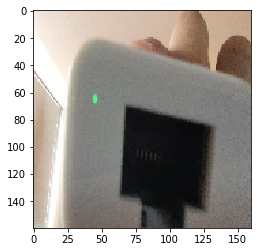

In [192]:
iterator = iter(ds_test2.batch(1).take(50))
print('What it predicts on random images: ')
prediction, result = -1, -1
for i in iterator:
    result = model.predict(i[0])
    prediction = int(np.clip(result[0][0], a_min=0, a_max=1))
    print(f'Predicted {labels[prediction]} for the image below')
    print(result)
    print(prediction)
    plt.imshow(i[0][0])
    plt.show()

In [196]:
#save_path = './model3/training/model.h5'
#model.save(save_path)

In [197]:
# Save JSON config to disk
#json_config = model.to_json()
#with open('./model3/training/model_config.json', 'w') as json_file:
#    json_file.write(json_config)
# Save weights to disk
#model.save_weights('./model3/training/weights.h5')